In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import BartTokenizer

In [11]:
df = pd.read_csv("clean.csv")
df = df.dropna(subset=['text', 'title'])
df = df.rename(columns={"text": "article", "title": "headline"})

In [12]:
df.head()

,headline,article,url
0,"'80s supermodel Kim Alexis, 64, talks the 'pre...",Kim Alexis was a regular on the cover of the S...,https://www.dailymail.co.uk/tvshowbiz/tvshowbi...
1,Buffy The Vampire Slayer fans in meltdown over...,Buffy fans were left overwhelmed with exciteme...,https://www.dailymail.co.uk/tvshowbiz/tvshowbi...
2,Cristiano Ronaldo's girlfriend hit Met Gala in...,Cristiano Ronaldo's girlfriend made her debut ...,https://www.dailymail.co.uk/tvshowbiz/tvshowbi...
3,Conor McGregor's fiancée Dee Devlin shares def...,Conor McGregor and fiancée Dee Devlin issued a...,https://www.dailymail.co.uk/tvshowbiz/tvshowbi...
4,"Has Liam Neeson finally found Love, Actually a...",'I'm madly in love with her. She's just terrif...,https://www.dailymail.co.uk/tvshowbiz/tvshowbi...


# General Data Quality and Distribution Analysis

### Sequence Length Distribution (Article vs. Headline)

In [4]:
# Add new columns for word counts
df['article_len'] = df['article'].str.split().apply(len)
df['headline_len'] = df['headline'].str.split().apply(len)

tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')

# Calculate tokenized length
df['article_len'] = df['article'].apply(lambda x: len(tokenizer.tokenize(x)))
df['headline_len'] = df['headline'].apply(lambda x: len(tokenizer.tokenize(x)))


W0722 14:42:40.987000 1477 site-packages/torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


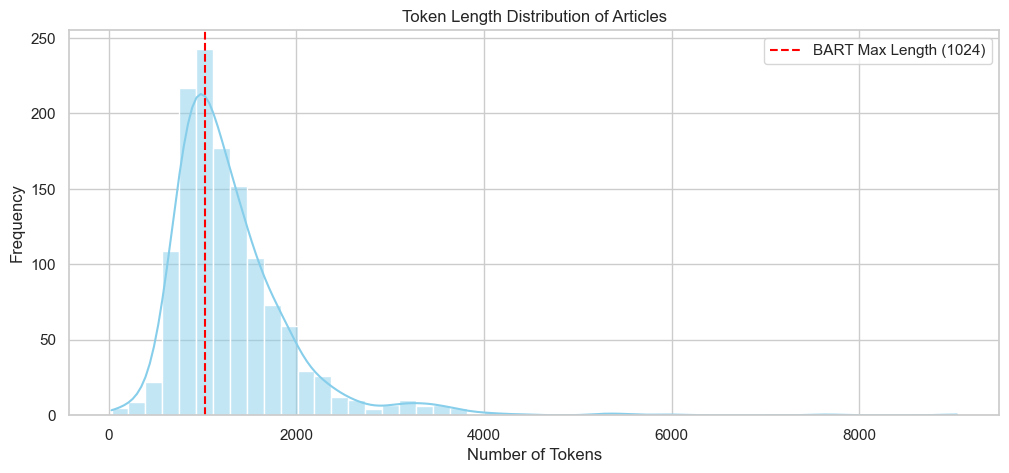

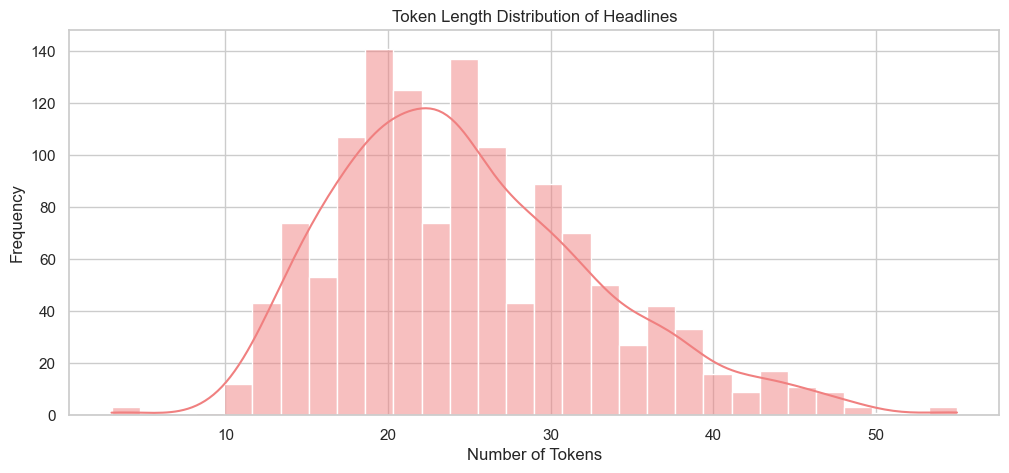

In [5]:
# Set plot style
sns.set(style="whitegrid")

# Plot article lengths
plt.figure(figsize=(12, 5))
sns.histplot(df['article_len'], bins=50, color='skyblue', kde=True)
plt.title("Token Length Distribution of Articles")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.axvline(x=1024, color='red', linestyle='--', label='BART Max Length (1024)')
plt.legend()
plt.show()

# Plot headline lengths
plt.figure(figsize=(12, 5))
sns.histplot(df['headline_len'], bins=30, color='lightcoral', kde=True)
plt.title("Token Length Distribution of Headlines")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()


In [6]:
print("Articles:\n", df['article_len'].describe())
print("Headlines:\n", df['headline_len'].describe())

# Spot very short or very long sequences
short_articles = df[df['article_len'] < 50]
long_articles = df[df['article_len'] > 1024]

short_headlines = df[df['headline_len'] < 3]
long_headlines = df[df['headline_len'] > 25]


Articles:
 count    1296.000000
mean     1314.952932
std       694.283377
min        32.000000
25%       899.000000
50%      1151.000000
75%      1552.250000
max      9039.000000
Name: article_len, dtype: float64
Headlines:
 count    1296.000000
mean       24.846451
std         8.085854
min         3.000000
25%        19.000000
50%        24.000000
75%        30.000000
max        55.000000
Name: headline_len, dtype: float64


In [7]:
#decision: delete the headline_len < 10 
df = df[df['headline_len']>10].reset_index(drop=True)

### Vocabulary Size and Token Frequency

In [8]:
import re

def clean_text(text):
    # Lowercase, remove special characters (keeping words and spaces), normalize spacing
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s']", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['clean_article'] = df['article'].apply(clean_text)
df['clean_headline'] = df['headline'].apply(clean_text)


In [9]:
from transformers import BartTokenizer
from collections import Counter

tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")

def get_tokens(text_series):
    tokens = []
    for text in text_series:
        tokens.extend(tokenizer.tokenize(text))
    return tokens

# Get token lists
article_tokens = get_tokens(df['clean_article'])
headline_tokens = get_tokens(df['clean_headline'])

# Token frequency
article_freq = Counter(article_tokens)
headline_freq = Counter(headline_tokens)


In [10]:
# Unique token counts
article_vocab_size = len(article_freq)
headline_vocab_size = len(headline_freq)

print(f"📘 Article Vocabulary Size: {article_vocab_size}")
print(f"📰 Headline Vocabulary Size: {headline_vocab_size}")


📘 Article Vocabulary Size: 23267
📰 Headline Vocabulary Size: 6366


In [11]:
print("🔝 Most common article tokens:")
print(article_freq.most_common(10))

print("\n🔝 Most common headline tokens:")
print(headline_freq.most_common(10))

print("\n🔻 Least frequent article tokens:")
print([token for token, count in article_freq.items() if count == 1][:10])


🔝 Most common article tokens:
[('Ġthe', 62436), ('Ġand', 32545), ('Ġa', 32360), ("Ġ'", 31895), ('Ġto', 31320), ('Ġin', 26990), ('Ġof', 24217), ('Ġher', 14567), ('Ġon', 13829), ('Ġwith', 12808)]

🔝 Most common headline tokens:
[("'", 540), ("Ġ'", 516), ('Ġin', 502), ("'s", 474), ('Ġto', 473), ('Ġthe', 458), ('Ġand', 408), ('Ġas', 404), ('Ġa', 362), ('Ġafter', 332)]

🔻 Least frequent article tokens:
['Ġcontemporaries', 'fortable', 'confidence', 'abl', 'impact', 'Ġcoats', 'atures', 'dinand', 'ventus', 'Ġacad']


In [12]:
# Get BART's vocabulary set
bart_vocab = set(tokenizer.get_vocab().keys())

def compute_oov_rate(token_list):
    oov_count = sum(1 for token in token_list if token not in bart_vocab)
    return oov_count / len(token_list)

article_oov_rate = compute_oov_rate(article_tokens)
headline_oov_rate = compute_oov_rate(headline_tokens)

print(f"🚫 OOV Rate (Articles): {article_oov_rate:.2%}")
print(f"🚫 OOV Rate (Headlines): {headline_oov_rate:.2%}")


🚫 OOV Rate (Articles): 0.00%
🚫 OOV Rate (Headlines): 0.00%


+ No Out-of-Vocabulary (OOV) Tokens: 
Every token in both articles and headlines is present in the BART tokenizer's vocabulary.

# Clickbait Specificity and Quality Evaluation

### Headline-Article Content Overlap (ROUGE):

In [14]:
from rouge_score import rouge_scorer
from tqdm import tqdm

In [19]:
import numpy as np

In [16]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Optional: lowercase for consistency
df['clean_article'] = df['article'].str.lower()
df['clean_headline'] = df['headline'].str.lower()

# Store scores
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

for i, row in tqdm(df.iterrows(), total=len(df)):
    scores = scorer.score(row['clean_headline'], row['clean_article'])  # headline is hypothesis, article is reference
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

# Add to DataFrame
df['rouge1'] = rouge1_scores
df['rouge2'] = rouge2_scores
df['rougeL'] = rougeL_scores


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1288/1288 [00:07<00:00, 172.93it/s]


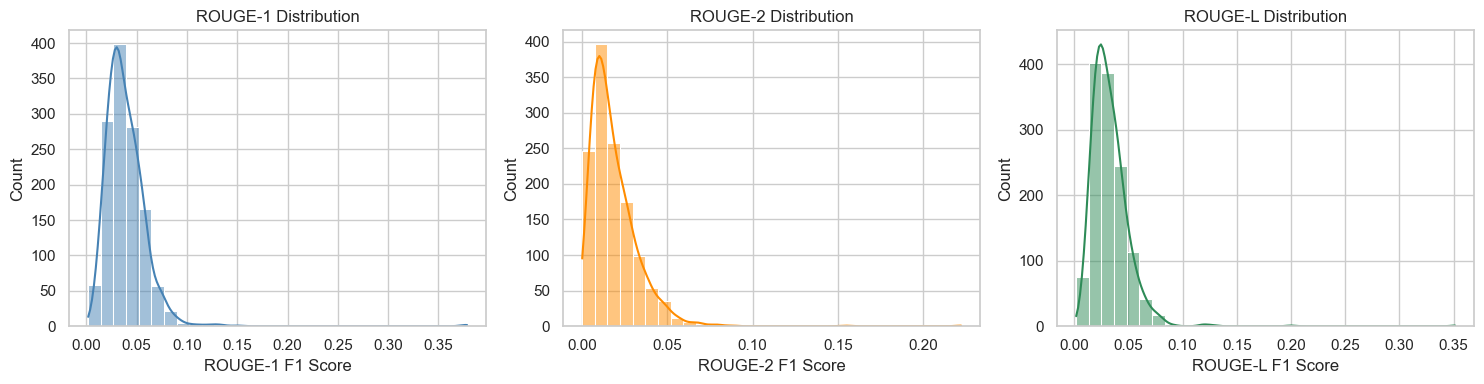

In [17]:

plt.figure(figsize=(15, 4))

# ROUGE-1
plt.subplot(1, 3, 1)
sns.histplot(df['rouge1'], bins=30, color='steelblue', kde=True)
plt.title('ROUGE-1 Distribution')
plt.xlabel('ROUGE-1 F1 Score')

# ROUGE-2
plt.subplot(1, 3, 2)
sns.histplot(df['rouge2'], bins=30, color='darkorange', kde=True)
plt.title('ROUGE-2 Distribution')
plt.xlabel('ROUGE-2 F1 Score')

# ROUGE-L
plt.subplot(1, 3, 3)
sns.histplot(df['rougeL'], bins=30, color='seagreen', kde=True)
plt.title('ROUGE-L Distribution')
plt.xlabel('ROUGE-L F1 Score')

plt.tight_layout()
plt.show()


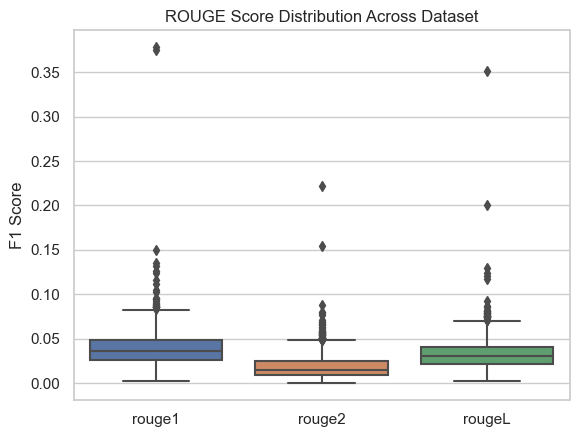

In [22]:
sns.boxplot(data=df[['rouge1', 'rouge2', 'rougeL']])
plt.title('ROUGE Score Distribution Across Dataset')
plt.ylabel('F1 Score')
plt.show()

In [20]:
print("Average ROUGE-1:", np.mean(df['rouge1']))
print("Average ROUGE-2:", np.mean(df['rouge2']))
print("Average ROUGE-L:", np.mean(df['rougeL']))


Average ROUGE-1: 0.03913376340196025
Average ROUGE-2: 0.018382008824989155
Average ROUGE-L: 0.03290567751347032


Traditional summarization aims for high ROUGE. Clickbait often diverges from direct summary. Lower ROUGE scores might actually indicate more "abstractive" or "clickbaity" headlines. Analyze the distribution of ROUGE scores.

These values are very low, which is exactly what you'd expect (and want) from clickbait-style headlines:

+ ROUGE-1 ≈ 4%: Even unigram (word-level) overlap is minimal.

+ ROUGE-2 ≈ 2%: Very little bigram overlap — almost no direct phrasing matches.

+ ROUGE-L ≈ 3%: No long subsequences in common.

This strongly indicates your headlines are highly abstractive and diverge sharply from the article content — classic characteristics of clickbait.



### Semantic Coherence/Consistency (Article to Headline):

#### Embedding Similarity (Sentence-BERT)

In [16]:
from sentence_transformers import SentenceTransformer, util
import torch

model = SentenceTransformer('all-MiniLM-L6-v2')

# Get embeddings
article_embeddings = model.encode(df['article'].tolist(), convert_to_tensor=True, show_progress_bar=True)
headline_embeddings = model.encode(df['headline'].tolist(), convert_to_tensor=True)

# Cosine similarity
cos_similarities = util.cos_sim(headline_embeddings, article_embeddings).diagonal()

# Add to DataFrame
df['semantic_similarity'] = cos_similarities.cpu().numpy()


Batches:   0%|                                                                                                                                                      | 0/41 [00:00<?, ?it/s]/Users/weiling/anaconda3/envs/analysis/lib/python3.11/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Batches: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:06<00:00,  6.72it/s]


In [17]:
df.head()

,headline,article,url,semantic_similarity
0,"'80s supermodel Kim Alexis, 64, talks the 'pre...",Kim Alexis was a regular on the cover of the S...,https://www.dailymail.co.uk/tvshowbiz/tvshowbi...,0.819281
1,Buffy The Vampire Slayer fans in meltdown over...,Buffy fans were left overwhelmed with exciteme...,https://www.dailymail.co.uk/tvshowbiz/tvshowbi...,0.524898
2,Cristiano Ronaldo's girlfriend hit Met Gala in...,Cristiano Ronaldo's girlfriend made her debut ...,https://www.dailymail.co.uk/tvshowbiz/tvshowbi...,0.762833
3,Conor McGregor's fiancée Dee Devlin shares def...,Conor McGregor and fiancée Dee Devlin issued a...,https://www.dailymail.co.uk/tvshowbiz/tvshowbi...,0.742045
4,"Has Liam Neeson finally found Love, Actually a...",'I'm madly in love with her. She's just terrif...,https://www.dailymail.co.uk/tvshowbiz/tvshowbi...,0.670645


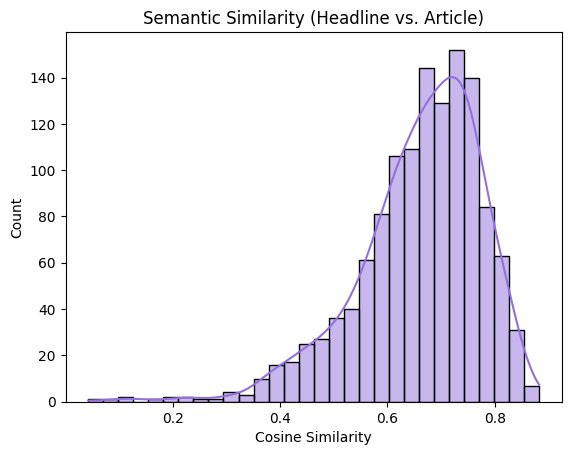

In [18]:

# Semantic similarity histogram
sns.histplot(df['semantic_similarity'], bins=30, color='mediumpurple', kde=True)
plt.title("Semantic Similarity (Headline vs. Article)")
plt.xlabel("Cosine Similarity")
plt.show()

# Correlation with keyword/entity overlap
#print(df[['semantic_similarity', 'keyword_overlap', 'entity_overlap']].corr())


Score Range	Meaning
+ > 0.8 Strongly semantically related
+ 0.5–0.8 Somewhat related, typical for good clickbait
+ < 0.5	Possibly off-topic or hallucinated headline
+ < 0.3	Likely irrelevant or misleading headline

#### 2. Keyword or Entity Overlap

In [20]:
from keybert import KeyBERT
kw_model = KeyBERT(model='all-MiniLM-L6-v2')

def keyword_overlap(article, headline, top_n=5):
    keywords = [kw[0] for kw in kw_model.extract_keywords(article, top_n=top_n, stop_words='english')]
    headline = headline.lower()
    return sum(1 for kw in keywords if kw.lower() in headline)

df['keyword_overlap'] = df.apply(lambda row: keyword_overlap(row['article'], row['headline']), axis=1)


In [22]:
import spacy
nlp = spacy.load("en_core_web_sm")

def entity_overlap(article, headline):
    doc = nlp(article)
    entities = set([ent.text.lower() for ent in doc.ents])
    return sum(1 for ent in entities if ent in headline.lower())

df['entity_overlap'] = df.apply(lambda row: entity_overlap(row['article'], row['headline']), axis=1)


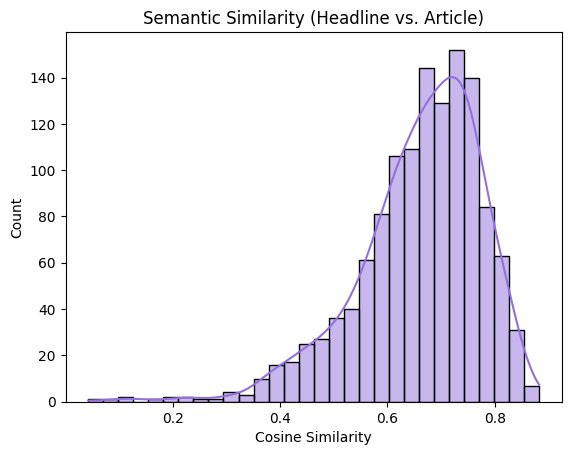

                     semantic_similarity  keyword_overlap  entity_overlap
semantic_similarity             1.000000         0.585206        0.423979
keyword_overlap                 0.585206         1.000000        0.416580
entity_overlap                  0.423979         0.416580        1.000000


In [23]:
# Semantic similarity histogram
sns.histplot(df['semantic_similarity'], bins=30, color='mediumpurple', kde=True)
plt.title("Semantic Similarity (Headline vs. Article)")
plt.xlabel("Cosine Similarity")
plt.show()

# Correlation with keyword/entity overlap
print(df[['semantic_similarity', 'keyword_overlap', 'entity_overlap']].corr())


### Style and Tone Analysis:

In [25]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    if not isinstance(text, str): return None
    score = analyzer.polarity_scores(text)
    return score['compound']  # ranges from -1 (very negative) to +1 (very positive)


In [26]:
df['headline_sentiment'] = df['headline'].apply(get_sentiment)
df['article_sentiment'] = df['article'].apply(get_sentiment)
df['sentiment_gap'] = df['headline_sentiment'] - df['article_sentiment']


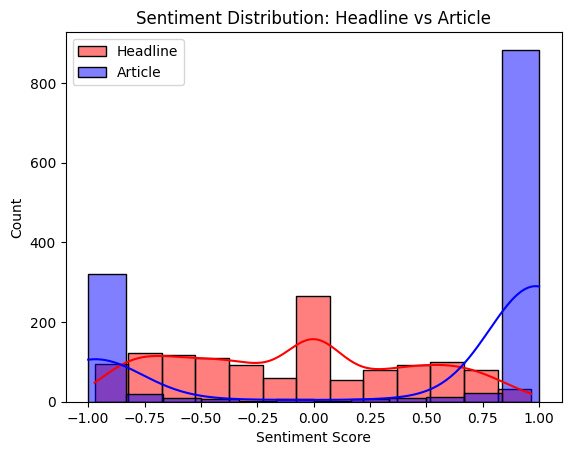

In [27]:
sns.histplot(df['headline_sentiment'], color='red', label='Headline', kde=True)
sns.histplot(df['article_sentiment'], color='blue', label='Article', kde=True)
plt.legend()
plt.title("Sentiment Distribution: Headline vs Article")
plt.xlabel("Sentiment Score")
plt.show()

Scenario	Implication
+ Most gaps > 0.3: 	You have sensational clickbait — great
+ Most gaps ≈ 0: More summary-style — less emotional engagement
+ Gaps < 0:	Headline is milder — not typical for clickbait

